In [ ]:
import pandas as pd
import numpy as np
import io

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data_new_with_quality_scores.csv to data_new_with_quality_scores.csv


Some lines need to be skipped as the csv's are extremely messy. If there is a way to clean them structurally, that might be better. For now I do it like this as it's not that many lines proportionally.

In [ ]:
pub = pd.read_csv('projectPublications.csv', sep=';', quotechar='"', on_bad_lines='skip')




In [ ]:
deliv = pd.read_csv('projectDeliverables.csv', sep=';', quotechar='"', on_bad_lines='skip');
rank = pd.read_excel('Journal Rankings OOIR.xlsx');

In [ ]:
projects = pd.read_csv('project.csv', sep=';', quotechar='"', on_bad_lines='skip')

In [ ]:
# Get the number of rows and columns for each DataFrame
pub_rows, pub_cols = pub.shape
deliv_rows, deliv_cols = deliv.shape
projects_rows, projects_cols = projects.shape
rank_rows, rank_cols = rank.shape

# Print the results
print(f"pub: {pub_rows} rows, {pub_cols} columns")
print(f"deliv: {deliv_rows} rows, {deliv_cols} columns")
print(f"projects: {projects_rows} rows, {projects_cols} columns")
print(f"rank: {rank_rows} rows, {rank_cols} columns")

pub: 21300 rows, 16 columns
deliv: 20804 rows, 10 columns
projects: 15221 rows, 20 columns
rank: 11608 rows, 7 columns


Original files sizes:

projectPublications - 21311 rows (difference: 11 rows (1 being titles))

projectDeliverables - 20816 rows (difference: 12 rows (1 being titles))

projects - 15342 (difference: 121 rows (1 being titles))


Skipped, incompatible, rows are extremely limited, as such we do not further inquire in these.

#Cleaning Journal ranks and journal name in publication file

Column in the publications file will need the same kind of handling

rank file based on: https://ooir.org/all-journals.php?metric=jif



In [ ]:
rank = rank.drop(columns=rank.columns[rank.columns.str.startswith('Unnamed')])

In [ ]:
# Clean JIF values and create a new numeric column
rank['JIF'] = (
    rank['Value']
    .str.replace('ca.', '', regex=False)
    .str.replace(',', '.', regex=False)
    .str.strip()
    .astype(float)
)

# Normalize journal names for matching (lowercase, remove punctuation/spaces)
rank['journal_clean'] = (
    rank['Journal']
    .str.lower()
    .str.replace(r"[^\w\s]", "", regex=True)  # remove punctuation
    .str.strip()
)
# Preview cleaned DataFrame
rank = rank[['journal_clean', 'JIF']]
rank.head()


,journal_clean,JIF
0,caa cancer journal for clinicians,503.1
1,nature reviews drug discovery,122.7
2,lancet,98.4
3,new england journal of medicine,96.2
4,nature reviews molecular cell biology,81.3


In [ ]:
rank['journal_clean'] = rank['journal_clean'].replace({
   'renewable sustainable energy reviews' : 'renewable and sustainable energy reviews'
})

For publications, sometimes the journal name is actually in title column instead of JournalTitle (see last row - EMBO journal). So both columns need cleaning to allow for matching.

In [ ]:
# Step 1: Ensure both columns are clean
pub['title_clean'] = (
    pub['title']
    .fillna('')
    .str.lower()
    .str.replace(r"[^\w\s]", "", regex=True)
    .str.strip()
)

pub['journal_clean'] = (
    pub['journalTitle']
    .fillna('')
    .str.lower()
    .str.replace(r"[^\w\s]", "", regex=True)
    .str.strip()
)

# Step 2: Create empty JIF column
pub['JIF'] = None


Some cases are manually identified to be classified wrongly, so we do these separately:

In [ ]:
pub['journal_clean'] = pub['journal_clean'].replace({
    'arxiv accepted for publication in jcap': 'journal of cosmology and astroparticle physics'
})
pub['journal_clean'] = pub['journal_clean'].replace({
    'jcap': 'journal of cosmology and astroparticle physics'
})
pub['journal_clean'] = pub['journal_clean'].replace({
    'renewable and sustainable energy reviews': 'renewable sustainable energy reviews'
})
pub['journal_clean'] = pub['journal_clean'].replace({
    'diagnostics': 'diagnostics'
})
pub['journal_clean'] = pub['journal_clean'].replace({
    'the astrophysical journal': 'astrophysical journal'
})

In [ ]:
# Strip leading/trailing and normalize internal whitespace
pub['journal_clean'] = pub['journal_clean'].str.strip().str.replace(r'\s+', ' ', regex=True)
rank['journal_clean'] = rank['journal_clean'].str.strip().str.replace(r'\s+', ' ', regex=True)


In [ ]:
# Step 3: Build dictionaries for fast lookup
journal_dict = dict(zip(rank['journal_clean'], rank['JIF']))
title_dict = dict(zip(rank['journal_clean'], rank['JIF']))  # fallback based on cleaned title

# Step 4: Try matching based on journal_clean
pub['JIF'] = pub['journal_clean'].map(journal_dict)

# Step 5: Fallback: only assign if still missing, based on title_clean
missing_mask = pub['JIF'].isna()
pub.loc[missing_mask, 'JIF'] = pub.loc[missing_mask, 'title_clean'].map(title_dict)

# Step 6: Summary
matched_pct = pub['JIF'].notna().mean()
print(f"Final match rate: {matched_pct:.2%}")

Final match rate: 43.63%


# Publication Value score


In [ ]:
type_points = {
    'Peer reviewed articles': 8,
    'Conference proceedings': 6,
    'Monographic books': 6,
    'Book chapters': 5,
    'Non-peer reviewed articles': 4,
    'Thesis and dissertations': 3,
    'Other': 2,
    'WorldFAIR Chemistry': 1
}
pub['type_points'] = pub['isPublishedAs'].map(type_points)

In [ ]:
# Example: log-scaled prestige boost to dampen extreme JIF values
pub['prestige_bonus'] = pub['JIF'].apply(lambda x: np.log1p(x) if pd.notna(x) else 0)

In [ ]:
pub['PubScore'] = pub['type_points'] + pub['prestige_bonus']


### Need to aggregate this to project level

In [ ]:
#Project ID in publciations file is also unique pub nummer attached, so for group ID we need the first 9 digits of this
# Create a new column with just the project-level ID
pub['project_group_id'] = pub['projectID'].str.extract(r'(\d{9})')

In [ ]:
project_pub_score = pub.groupby('project_group_id')['PubScore'].sum().reset_index()
project_pub_score.columns = ['projectID', 'TotalPubScore']


In [ ]:
project_pub_score

,projectID,TotalPubScore
0,101039048,17.481605
1,101039066,109.609159
2,101039090,76.000000
3,101039103,171.909234
4,101039110,37.472859
...,...,...
3573,190195939,12.000000
3574,190196128,15.722767
3575,190198093,8.000000
3576,190198323,16.000000


In [ ]:
projects = projects.rename(columns={'id': 'projectID'})
projects['projectID'] = projects['projectID'].astype(str)
project_pub_score['projectID'] = project_pub_score['projectID'].astype(str)
projects = projects.merge(project_pub_score, on='projectID', how='left')

In [ ]:
# How many IDs are common between the two datasets
shared_ids = set(projects['projectID']) & set(project_pub_score['projectID'])
print(f"Shared project IDs: {len(shared_ids)}")
print("Example shared IDs:", list(shared_ids)[:5])

Shared project IDs: 3546
Example shared IDs: ['101101967', '101073263', '101079774', '101103772', '101075709']


In [ ]:
project_pub_score['projectID'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 3578 entries, 0 to 3577
Series name: projectID
Non-Null Count  Dtype 
--------------  ----- 
3578 non-null   object
dtypes: object(1)
memory usage: 28.1+ KB


Fill the nan with 0, to convey no output:


In [ ]:
projects['TotalPubScore'] = projects['TotalPubScore'].fillna(0)


In [ ]:
projects[['TotalPubScore']]

,TotalPubScore
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
15216,0.0
15217,0.0
15218,0.0
15219,0.0


#Number of publications

In [ ]:
# NumPublications (count of publications per project)
pub_count = pub.groupby('project_group_id').size().reset_index(name='NumPublications')
pub_count.columns = ['projectID', 'NumPublications']

In [ ]:
pub_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3578 entries, 0 to 3577
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   projectID        3578 non-null   object
 1   NumPublications  3578 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 56.0+ KB


In [ ]:
pub_count['projectID'] = pub_count['projectID'].astype(str)

In [ ]:
# Merge
projects = projects.merge(pub_count, on='projectID', how='left')

# Fill missing values with 0 (projects without publications)
projects['NumPublications'] = projects['NumPublications'].fillna(0)


#Number of Deliverables

In [ ]:
# Extract the 9-digit group project ID from deliverables
deliv['project_group_id'] = deliv['projectID'].astype(str).str.extract(r'(\d{9})')


In [ ]:
# Count deliverables per project group
deliv_count = deliv.groupby('project_group_id').size().reset_index(name='NumDeliverables')
deliv_count.columns = ['projectID', 'NumDeliverables']  # for merge


In [ ]:
deliv_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5548 entries, 0 to 5547
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   projectID        5548 non-null   object
 1   NumDeliverables  5548 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 86.8+ KB


In [ ]:
# Make sure types match before merging
projects['projectID'] = projects['projectID'].astype(str)
deliv_count['projectID'] = deliv_count['projectID'].astype(str)

# Merge deliverable count
projects = projects.merge(deliv_count, on='projectID', how='left')
projects['NumDeliverables'] = projects['NumDeliverables'].fillna(0)


In [ ]:
# View unique values (optional: sample only the first 10 for readability)
print("Unique TotalPubScore values (sample):", projects['TotalPubScore'].dropna().unique()[:10])
print("Unique NumPublications values:", sorted(projects['NumPublications'].dropna().unique()))
print("Unique NumDeliverables values:", sorted(projects['NumDeliverables'].dropna().unique()))

# Count how many projects have data for each
num_with_pub_score = projects['TotalPubScore'].notna().sum()
num_with_pub_count = (projects['NumPublications'] > 0).sum()
num_with_deliv_count = (projects['NumDeliverables'] > 0).sum()

print("\nProjects with TotalPubScore", num_with_pub_score)
print("Projects with NumPublications > 0:", num_with_pub_count)
print("Projects with NumDeliverables > 0:", num_with_deliv_count)

# Optional: overlap — how many projects have both pubs and deliverables
both_pub_and_deliv = ((projects['NumPublications'] > 0) | (projects['NumDeliverables'] > 0)).sum()
only_pub = ((projects['NumPublications'] > 0) & (projects['NumDeliverables'] == 0)).sum()
only_deliv = ((projects['NumPublications'] == 0) & (projects['NumDeliverables'] > 0)).sum()

print("\nProjects with Either publications and deliverables:", both_pub_and_deliv)
print("Projects with only publications:", only_pub)
print("Projects with only deliverables:", only_deliv)


Unique TotalPubScore values (sample): [ 0.          2.          6.         12.          5.         17.36097655
  9.56861592 16.          8.         25.17847041]
Unique NumPublications values: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(15.0), np.float64(16.0), np.float64(17.0), np.float64(18.0), np.float64(19.0), np.float64(20.0), np.float64(21.0), np.float64(22.0), np.float64(23.0), np.float64(24.0), np.float64(25.0), np.float64(26.0), np.float64(27.0), np.float64(28.0), np.float64(29.0), np.float64(30.0), np.float64(31.0), np.float64(32.0), np.float64(33.0), np.float64(34.0), np.float64(35.0), np.float64(36.0), np.float64(37.0), np.float64(38.0), np.float64(41.0), np.float64(42.0), np.float64(43.0), np.float64(44.0), np.float64(45.0), np.float64(46.0), np.floa

#Normalizing the three features

By month

In [ ]:
from datetime import datetime

# Convert start date
projects['startDate'] = pd.to_datetime(projects['startDate'], errors='coerce')

# Set reference date
reference_date = pd.to_datetime('2025-05-01')

# Age in months
projects['ProjectAgeMonths'] = ((reference_date - projects['startDate']) / pd.Timedelta(days=30)).round(1)

# Avoid zero-division by setting minimum age to 1 month
projects['ProjectAgeMonths'] = projects['ProjectAgeMonths'].apply(lambda x: max(x, 1))


In [ ]:
# Compute per-month scores
projects['PubScore_per_month'] = projects['TotalPubScore'] / projects['ProjectAgeMonths']
projects['NumPubs_per_month'] = projects['NumPublications'] / projects['ProjectAgeMonths']
projects['NumDeliv_per_month'] = projects['NumDeliverables'] / projects['ProjectAgeMonths']


In [ ]:
projects[['startDate', 'ProjectAgeMonths']]

,startDate,ProjectAgeMonths
0,2024-02-01,15.2
1,2025-08-01,1.0
2,2025-06-01,1.0
3,2025-05-01,1.0
4,2025-03-01,2.0
...,...,...
15216,2023-07-01,22.3
15217,2023-07-01,22.3
15218,2023-07-01,22.3
15219,2023-07-01,22.3


# Creating the OQI Output Quality Index
Suggestion: OQI = 0.5 TotalPubScore + 0.3 NumPublications + 0.2 NumDeliverables

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalize per-month values
scaler = MinMaxScaler()
projects[['PubScore_month_scaled', 'NumPubs_month_scaled', 'NumDeliv_month_scaled']] = scaler.fit_transform(
    projects[['PubScore_per_month', 'NumPubs_per_month', 'NumDeliv_per_month']]
)

# Final time-normalized OQI (monthly basis)
projects['OQI_month_norm'] = (
    0.5 * projects['PubScore_month_scaled'] +
    0.3 * projects['NumPubs_month_scaled'] +
    0.2 * projects['NumDeliv_month_scaled']
)


In [ ]:
# View top projects by OQI
projects[['projectID', 'OQI_month_norm']].sort_values(by='OQI_month_norm', ascending=False).head(10)


,projectID,OQI_month_norm
14012,101052200,1.000000
257,101058393,0.179861
11066,101061037,0.167116
75,101113078,0.160487
169,101113151,0.160487
2584,101056866,0.152833
11084,101165375,0.140426
9344,101058245,0.137398
1472,101055286,0.136735
11647,101056765,0.134669


eg project 101052200 is therefore the highest ranked in all three categories.

In [ ]:
from google.colab import files

# Save the DataFrame to a CSV file
projects.to_csv('projects_with_OQI.csv', index=False)  # index=False to avoid saving row index

files.download('projects_with_OQI.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Grid search for sensitivity analysis
Want to find the weighing combination that leads to the least variability in  project rankings across different configurations. This makes it so that the eventual OQI is less sensitive to small changes in assumptions.  

In [ ]:
import itertools
import pandas as pd

# Define grid search space
pub_score_weights = [0.5, 0.6, 0.7, 0.8]
num_pubs_weights = [0.1, 0.2, 0.3, 0.4]
num_deliv_weights = [0.0, 0.1, 0.2]

# Generate all combinations where weights sum to 1
grid = [
    (w1, w2, w3)
    for w1, w2, w3 in itertools.product(pub_score_weights, num_pubs_weights, num_deliv_weights)
    if abs(w1 + w2 + w3 - 1.0) < 1e-5
]

# Initialize top_6697_sets before the loop
top_6697_sets = []  # This line was missing

for w1, w2, w3 in grid:
    projects['OQI_temp'] = (
        w1 * projects['PubScore_month_scaled'] +
        w2 * projects['NumPubs_month_scaled'] +
        w3 * projects['NumDeliv_month_scaled']
    )
    top_6697_ids = set(projects.sort_values('OQI_temp', ascending=False).head(6697)['projectID'])
    top_6697_sets.append({
        'w_quality': w1,
        'w_quantity': w2,
        'w_deliv': w3,
        'top_100_projects': top_6697_ids
    })

In [ ]:
from itertools import combinations
import numpy as np

jaccard_scores = []

for i, j in combinations(range(len(top_6697_sets)), 2):
    set_i = top_6697_sets[i]['top_100_projects']
    set_j = top_6697_sets[j]['top_100_projects']
    jaccard = len(set_i & set_j) / len(set_i | set_j)
    jaccard_scores.append({'i': i, 'j': j, 'jaccard': jaccard})


In [ ]:
from collections import defaultdict

mean_jaccard = defaultdict(list)

for row in jaccard_scores:
    mean_jaccard[row['i']].append(row['jaccard'])
    mean_jaccard[row['j']].append(row['jaccard'])

# Now compute mean similarity per weight config
avg_similarity = {
    idx: np.mean(scores)
    for idx, scores in mean_jaccard.items()
}


In [ ]:
most_stable_index = max(avg_similarity, key=avg_similarity.get)
most_stable_weights = {
    key: top_6697_sets[most_stable_index][key]
    for key in ['w_quality', 'w_quantity', 'w_deliv']
}

print("Most stable weight combination:")
print(most_stable_weights)


Most stable weight combination:
{'w_quality': 0.5, 'w_quantity': 0.3, 'w_deliv': 0.2}


In [ ]:
stable_df = pd.DataFrame([
    {
        'index': i,
        'w_quality': top_6697_sets[i]['w_quality'],
        'w_quantity': top_6697_sets[i]['w_quantity'],
        'w_deliv': top_6697_sets[i]['w_deliv'],
        'avg_jaccard': avg_similarity[i]
    }
    for i in avg_similarity
])

stable_df = stable_df.sort_values(by='avg_jaccard', ascending=False)
stable_df.head(5)


,index,w_quality,w_quantity,w_deliv,avg_jaccard
0,0,0.5,0.3,0.2,0.839054
1,1,0.5,0.4,0.1,0.839054
2,2,0.6,0.2,0.2,0.839054
3,3,0.6,0.3,0.1,0.839054
5,5,0.7,0.1,0.2,0.839054


So apparently based on the sensitivity analysis (jaccard scores), the original weights we chose turn out to be the most stable across the weight configurations. Those weights minimize the sensitivity to minor changes in assumptions and consistently identify the high performing projects, making it robust and defensible. The weight configurations were chosen based on our emphasis to have quality over quantity (external validation --> being reviewed to be published in a journal has more scientific quality. Quantity was then included to reflect research productivity to recognize output effort.

#EDA

In [ ]:
df = pd.read_csv('data_new_with_quality_scores.csv')

In [ ]:
print(df.head())
print(df.info())

   projectID  status   startDate     endDate  totalCost  ecMaxContribution  \
0  101116741  SIGNED  2024-02-01  2029-01-31    1499998            1499998   
1  101162875  SIGNED  2025-03-01  2030-02-28    1500000            1500000   
2  101167314  SIGNED  2025-04-01  2031-03-31   11982258           11982258   
3  101072693  SIGNED  2022-08-01  2024-07-31     100000             100000   
4  101172406  SIGNED  2024-07-01  2025-12-31     608440             300000   

   OQI_month_norm country           region  region_code  ... sub_fund_code  \
0        0.000000      NL   Western Europe            1  ...             1   
1        0.000000      IT  Southern Europe            3  ...             1   
2        0.000000      IT  Southern Europe            3  ...             1   
3        0.021259      UA   Eastern Europe            4  ...             4   
4        0.000000      PL   Eastern Europe            4  ...             4   

   organizationCount countryCount  europeanCountryCount  \
0  

In [ ]:
# Calculate the correlation matrix, excluding non-numeric columns
correlation_matrix = df.corr(numeric_only=True)
print(correlation_matrix)

                               projectID  totalCost  ecMaxContribution  \
projectID                       1.000000   0.002507          -0.025783   
totalCost                       0.002507   1.000000           0.521697   
ecMaxContribution              -0.025783   0.521697           1.000000   
OQI_month_norm                 -0.058843   0.096252           0.055197   
region_code                    -0.031980  -0.007883          -0.007002   
topic_code                      0.046042   0.048705           0.068514   
sub_fund_code                   0.160789   0.124110           0.152125   
organizationCount              -0.104914   0.319235           0.284328   
countryCount                   -0.120805   0.273576           0.252884   
europeanCountryCount           -0.119912   0.275216           0.260798   
countryDiversityIndex          -0.149556   0.185903           0.225626   
europeanOrganizationRatio      -0.006257   0.018717           0.029635   
geoCentralizationIndex(KM)     -0.1075

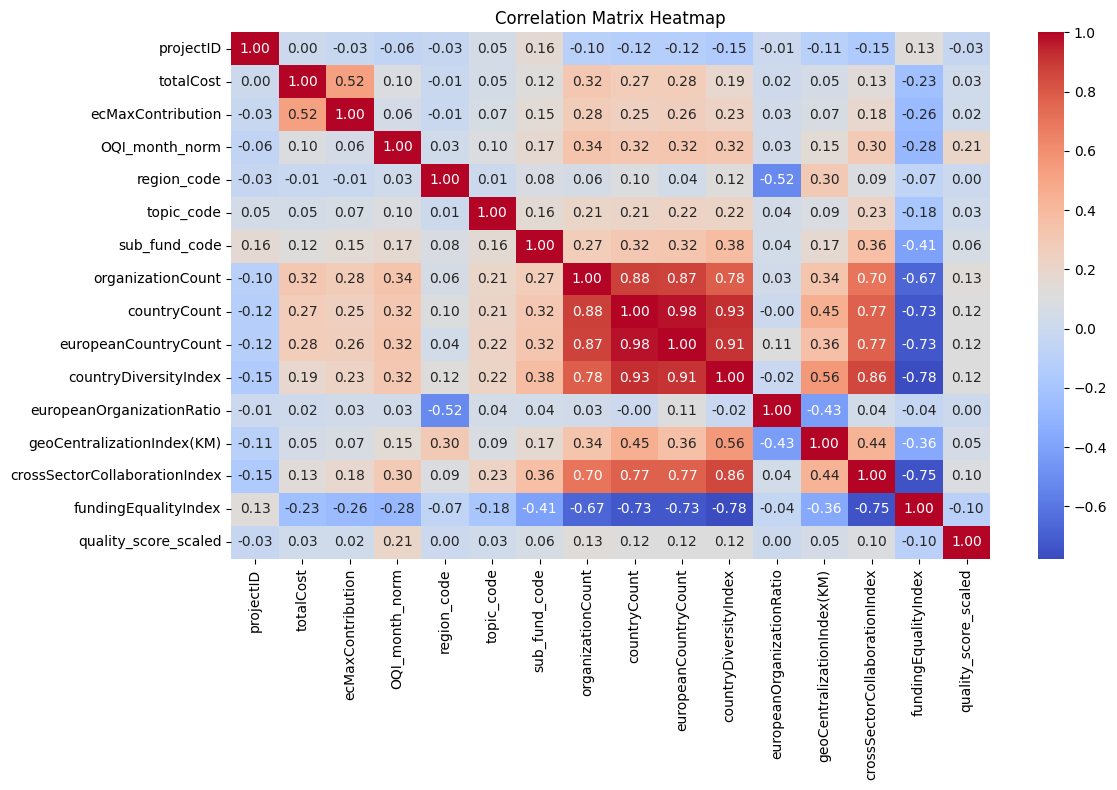

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume correlation_matrix has already been calculated
# If not, make sure the previous step calculating correlation_matrix runs first:
# correlation_matrix = df.corr(numeric_only=True)


# Set the figure size
plt.figure(figsize=(12, 8))

# Create the heatmap
# annot=True displays the correlation values on the heatmap
# cmap='coolwarm' sets the color scheme (blue for negative, red for positive)
# fmt=".2f" formats the annotations to two decimal places
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Add a title to the heatmap
plt.title('Correlation Matrix Heatmap')

# Adjust layout to prevent labels overlapping
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
print(df['OQI_month_norm'].describe())

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['OQI_month_norm'], kde=True)
plt.title('Distribution of OQI_month_norm')
plt.xlabel('OQI_month_norm')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['OQI_month_norm'])
plt.title('Box Plot of OQI_month_norm')
plt.xlabel('OQI_month_norm')
plt.show()